# Create the Environment

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding
import matplotlib.pyplot as plt
import os

# Download Text Data

In [2]:
file_URL = "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
file_name= "shakespeare.txt"
# get the file path
path = keras.utils.get_file(file_name, file_URL)

1122304/1115394 [==============================] - 0s 0us/step


In [3]:
raw = open(path, 'rb').read()
print(raw[250:400])

b"\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it "


In [4]:
text = raw.decode(encoding='utf-8')
print(text[250:400])


All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


In [5]:
len(text)

1115394

# Vectorize Word Characters into Integers

In [6]:
# unique characters
vocabulary = np.array(sorted(set(text)))
len(vocabulary)

65

In [7]:
# assign an integer to each character
tokenizer = {char:i for i,char in enumerate(vocabulary)}

In [8]:
# check characters and its corresponding integer

for i in range(20):
    char = vocabulary[i]
    token = tokenizer[char]
    print('%4s : %4d'%(repr(char),token))

'\n' :    0
 ' ' :    1
 '!' :    2
 '$' :    3
 '&' :    4
 "'" :    5
 ',' :    6
 '-' :    7
 '.' :    8
 '3' :    9
 ':' :   10
 ';' :   11
 '?' :   12
 'A' :   13
 'B' :   14
 'C' :   15
 'D' :   16
 'E' :   17
 'F' :   18
 'G' :   19


In [9]:
vector = np.array([tokenizer[char] for char in text])

print('\nSample Text \n')
print('-'*70)
print(text[:100])
print('-'*70)
print('\n\nCorresponding Integer Vector \n')
print('-'*70)
print(vector[:100])
print('-'*70)



Sample Text 

----------------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
----------------------------------------------------------------------


Corresponding Integer Vector 

----------------------------------------------------------------------
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59]
----------------------------------------------------------------------


In [10]:
# convert into tensors
vector = tf.data.Dataset.from_tensor_slices(vector)

# make sequences each of length 100 characters
sequences = vector.batch(100, drop_remainder=True)

In [11]:
def prepare_dataset(seq):
    input_vector = seq[:-1]
    target_vector = seq[1:]
    return input_vector, target_vector

dataset = sequences.map(prepare_dataset)

In [12]:
# check how it looks

for inp, tar in dataset.take(1):
    print(inp.numpy())
    print(tar.numpy())
    inp_text = ''.join(vocabulary[inp])
    tar_text = ''.join(vocabulary[tar])
    print(repr(inp_text))
    print(repr(tar_text))

[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53]
[47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43  1
 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43 39
 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49  6
  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0
 37 53 59]
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYo'
'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'


# Batch and Prefetch Dataset

In [13]:
# number of batched sequences
len(sequences)//64

174

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
# buffer size 10000
# batch size 64
data = dataset.batch(64, drop_remainder=True).repeat()
data = data.prefetch(AUTOTUNE)
# steps per epoch is number of batches available
STEPS_PER_EPOCH = len(sequences)//64

In [15]:
for inp, tar in data.take(1):
    print(inp.numpy().shape)
    print(tar.numpy().shape)

(64, 99)
(64, 99)


# Build Model

In [16]:
model = keras.Sequential([
    # Embed len(vocabulary) into 64 dimensions
    Embedding(len(vocabulary), 64, batch_input_shape=[64,None]),
    # LSTM RNN layers
    LSTM(512, return_sequences=True, stateful=True),
    LSTM(512, return_sequences=True, stateful=True),
    # Classification head
    Dense(len(vocabulary))
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 64)            4160      
_________________________________________________________________
lstm (LSTM)                  (64, None, 512)           1181696   
_________________________________________________________________
lstm_1 (LSTM)                (64, None, 512)           2099200   
_________________________________________________________________
dense (Dense)                (64, None, 65)            33345     
Total params: 3,318,401
Trainable params: 3,318,401
Non-trainable params: 0
_________________________________________________________________


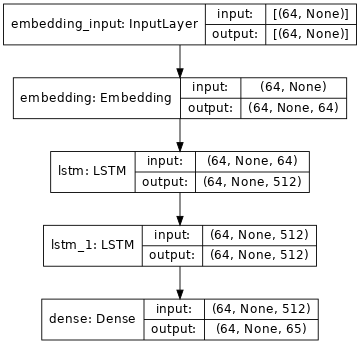

In [18]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

# Train the Model

In [19]:
# test whether model performs good

for example_inp, example_tar in data.take(1):
    example_pred = model(example_inp)
    print(example_tar.numpy().shape)
    print(example_pred.shape)
    

(64, 99)
(64, 99, 65)


In [20]:
ids = tf.random.categorical(example_pred[0], num_samples=1)
ids.shape

TensorShape([99, 1])

In [21]:
ids[0][-1].numpy()

27

In [22]:
# callback to save checkpoints
checkpoint_path = os.path.join("./checkpoints", "ckpt_{epoch}")
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

In [23]:
model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

history = model.fit(data, 
                    epochs=10, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    callbacks=[checkpoint_callback])

Epoch 1/10
174/174 [==============================] - 364s 2s/step - loss: 3.4031
Epoch 2/10
174/174 [==============================] - 355s 2s/step - loss: 2.4450
Epoch 3/10
174/174 [==============================] - 357s 2s/step - loss: 2.1154
Epoch 4/10
174/174 [==============================] - 357s 2s/step - loss: 1.9102
Epoch 5/10
174/174 [==============================] - 354s 2s/step - loss: 1.7560
Epoch 6/10
174/174 [==============================] - 355s 2s/step - loss: 1.6403
Epoch 7/10
174/174 [==============================] - 356s 2s/step - loss: 1.5536
Epoch 8/10
174/174 [==============================] - 353s 2s/step - loss: 1.4871
Epoch 9/10
174/174 [==============================] - 357s 2s/step - loss: 1.4351
Epoch 10/10
174/174 [==============================] - 353s 2s/step - loss: 1.3939


# Performance Evaluation

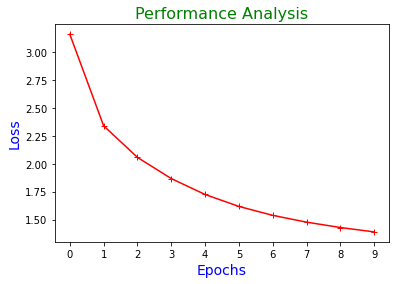

In [24]:
plt.plot(history.history['loss'], '+-r')
plt.title('Performance Analysis', size=16, color='green')
plt.xlabel('Epochs', size=14, color='blue')
plt.ylabel('Loss', size=14, color='blue')
plt.xticks(range(10))
plt.show()

# Inference - Next Character Prediction

In [26]:
# reset previous states of model
model.reset_states()

In [42]:
sample = 'ANTHONIO:'
# vectorize the string
sample_vector = [tokenizer[s] for s in sample]
predicted = sample_vector
# convert into tensor of required dimensions
sample_tensor = tf.expand_dims(sample_vector, 0) 
# broadcast to first dimension to 64 
sample_tensor = tf.repeat(sample_tensor, 64, axis=0)

# predict next 1000 characters
# temperature is a sensitive variable to adjust prediction
temperature = 0.6
for i in range(1000):
    pred = model(sample_tensor)
    # reduce unnecessary dimensions
    pred = pred[0].numpy()/temperature
    pred = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
    predicted.append(pred)
    sample_tensor = predicted[-99:]
    sample_tensor = tf.expand_dims([pred],0)
    # broadcast to first dimension to 64 
    sample_tensor = tf.repeat(sample_tensor, 64, axis=0)
    


In [43]:
pred_char = [vocabulary[i] for i in predicted]
generated = ''.join(pred_char)
print(generated)

ANTHONIO:
What are you which never was the trie would
And in the strong will night not did the moon:
Pridot me you then be so good the more than the moor
A mistress in the way a most about so then
Come with the steed but what with him that swore.

GRUMIO:
And then you come to way the mine of
a right to be made thee well.

PETRUCHIO:
What is the mistress of my son:
And Mirth you him to your life.

ANTONIO:
Hark, sir, what, not here in my sense out.

PETRUCHIO:
Ay, sir, this young.

Provost:
I am head, and all the sen where the house of a little with the
house, my love, having the pettit is all
the curner of the lives be ready to my sister then
From the new company.

PROSPERO:
I have been from the midst such a desperit of his time.

BAPTISTA:
I may be then to be a master 'stall in her death.

GRUMIO:
But what you must be beauthing sorry.

PETRUCHIO:
Pray, be long too shall be presently,
stays to thy consciench.

PETRUCHIO:
I can lie thee to the bid and
The word of my father, what is is t

### vary temperature to see yet different prediction

In [ ]:
sample = 'ANTHONIO:'
# vectorize the string
sample_vector = [tokenizer[s] for s in sample]
predicted = sample_vector
# convert into tensor of required dimensions
sample_tensor = tf.expand_dims(sample_vector, 0) 
# broadcast to first dimension to 64 
sample_tensor = tf.repeat(sample_tensor, 64, axis=0)

# predict next 1000 characters
# vary temperature to change randomness
temperature = 0.8
for i in range(1000):
    pred = model(sample_tensor)
    # reduce unnecessary dimensions
    pred = pred[0].numpy()/temperature
    pred = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
    predicted.append(pred)
    sample_tensor = predicted[-99:]
    sample_tensor = tf.expand_dims([pred],0)
    # broadcast to first dimension to 64 
    sample_tensor = tf.repeat(sample_tensor, 64, axis=0)
    


In [39]:
pred_char = [vocabulary[i] for i in predicted]
generated = ''.join(pred_char)
print(generated)

ANTHONIO:
Now, I have not so early debeits and secret what then
Hath been and leaves and speak to please you, your widow driblest.

MIRANDA:
What is naw't shall now call her cheer him
Thine own reputed anchor all. Pest, not hell!

DAKE ANTIUS:
Sir, then he that have been the dank in the
great amorn'd myst you the Pribs Henry,
There are children of the still stand him.

GRUMIO:
What shall no pass are love not so receiveds and all,
What mistress lost and talk! shall he come proclaim in dich,
When 'tis begire the servant rather father
from thy chimate, sir; suppiar with the met
As widow the lost me well and I may never;
Therefore Prance your good remimble bid her birds.

PETRUCHIO:
God good with his fanst from my wife.
O at thus thou artwain on the world!
So more off me mean a will of shame,
Have they seem the house the names not some too;
I pray you, or olders arispr o' the
more tobergey.

Pedant:
Sir, sir, I proceed?

GREMIO:
Thy did and for a gentlewat for his temper old
And made hears

### Thank You For Your Time!